In [155]:
# !pip install torch
# !pip install torchvision

In [156]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [157]:
# FC VAE Architecture
class FCVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(FCVAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2)).view(-1, 3, 32, 32)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [158]:
# Conv VAE Architecture
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)

        self.conv_mu = nn.Conv2d(256, latent_dim, kernel_size=2)
        self.conv_logvar = nn.Conv2d(256, latent_dim, kernel_size=2)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose2d(latent_dim, 256, 2, stride=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):    
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))

        mu = self.conv_mu(x).squeeze(-1).squeeze(-1)
        logvar = self.conv_logvar(x).squeeze(-1).squeeze(-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = z.unsqueeze(-1).unsqueeze(-1)
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.relu(self.deconv4(x))
        x = self.sigmoid(self.deconv5(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [159]:
# Loss function
def loss_function_cvae(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD, MSE, KLD

def loss_function_fcvae(recon_x, x, mu, logvar, beta=1):    
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 3072), x.view(-1, 3072), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

In [160]:
# Training the VAE
def train(model, train_loader, optimizer, epoch, num_epochs, model_name, device):
    model.train()
    train_loss_total = 0
    recon_loss_total = 0
    kld_loss_total = 0
    with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}', colour='green') as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            if model_name == 'cvae':
                data = data.view(data.size(0), 3, 32, 32).to(device)
            elif model_name == 'fcvae':
                data = data.view(data.size(0), -1).to(device)   
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            if model_name == 'cvae':
                loss_function = loss_function_cvae
            elif model_name == 'fcvae':
                loss_function = loss_function_fcvae
            total_loss, recon_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
            total_loss.backward()
            train_loss_total += total_loss.item()
            recon_loss_total += recon_loss.item()
            kld_loss_total += kld_loss.item()
            optimizer.step()
            tepoch.set_postfix(
                train_loss=train_loss_total / len(train_loader.dataset),
                recon_loss=recon_loss_total / len(train_loader.dataset),
                kld_loss=kld_loss_total / len(train_loader.dataset)
            )
    print(f'Epoch {epoch}/{num_epochs} train loss: {train_loss_total / len(train_loader.dataset)} mse loss: {recon_loss_total / len(train_loader.dataset)} kld loss: {kld_loss_total / len(train_loader.dataset)}')

In [161]:
num_epochs = 5

In [162]:
# Train the CVAE
transform_cvae = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset_cvae = datasets.CIFAR10('./data/cvae', train=True, download=True, transform=transform_cvae)
train_loader_cvae = torch.utils.data.DataLoader(train_dataset_cvae, batch_size=128, shuffle=True)

cvae = ConvVAE(latent_dim=128)
optimizer_cvae = optim.Adam(cvae.parameters(), lr=5e-3, weight_decay=1e-5)

for epoch in range(1, num_epochs + 1):
    train(cvae, train_loader_cvae, optimizer_cvae, epoch, num_epochs, 'cvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 391/391 [01:55<00:00,  3.38batch/s, kld_loss=1.98, recon_loss=773, train_loss=775]   


Epoch 1/5 train loss: 775.102670078125 mse loss: 773.125313046875 kld loss: 1.9773569729053975


Epoch 2: 100%|██████████| 391/391 [01:40<00:00,  3.90batch/s, kld_loss=16.7, recon_loss=611, train_loss=627]  


Epoch 2/5 train loss: 627.406201796875 mse loss: 610.677616328125 kld loss: 16.728586943359375


Epoch 3: 100%|██████████| 391/391 [01:35<00:00,  4.08batch/s, kld_loss=17.9, recon_loss=574, train_loss=592]  


Epoch 3/5 train loss: 591.77944453125 mse loss: 573.9196059375 kld loss: 17.85983885986328


Epoch 4: 100%|██████████| 391/391 [01:42<00:00,  3.80batch/s, kld_loss=18.2, recon_loss=559, train_loss=577]  


Epoch 4/5 train loss: 577.475263984375 mse loss: 559.297343828125 kld loss: 18.177918791503906


Epoch 5: 100%|██████████| 391/391 [02:17<00:00,  2.85batch/s, kld_loss=19.1, recon_loss=551, train_loss=570]  

Epoch 5/5 train loss: 570.115939921875 mse loss: 550.978788671875 kld loss: 19.137150241699217


In [163]:
# Train the FCVAE
transform_fcvae = transforms.Compose([
    transforms.ToTensor()
])

train_dataset_fcvae = datasets.CIFAR10('./data/fcvae', train=True, download=True, transform=transform_fcvae)
train_loader_fcvae = torch.utils.data.DataLoader(train_dataset_fcvae, batch_size=128, shuffle=True)

fcvae = FCVAE(input_dim=3072, hidden_dim=400, latent_dim=128)
optimizer_fcvae = optim.Adam(fcvae.parameters(), lr=5e-3, weight_decay=1e-5)

for epoch in range(1, num_epochs + 1):
    train(fcvae, train_loader_fcvae, optimizer_fcvae, epoch, num_epochs, 'fcvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 391/391 [00:28<00:00, 13.68batch/s, kld_loss=23.3, recon_loss=1.98e+3, train_loss=2e+3]   


Epoch 1/5 train loss: 1998.4208240625 mse loss: 1975.1220728125 kld loss: 23.29875025817871


Epoch 2: 100%|██████████| 391/391 [00:28<00:00, 13.55batch/s, kld_loss=12.6, recon_loss=1.94e+3, train_loss=1.95e+3]


Epoch 2/5 train loss: 1949.1371115625 mse loss: 1936.5471675 kld loss: 12.58994312133789


Epoch 3: 100%|██████████| 391/391 [00:30<00:00, 12.65batch/s, kld_loss=10.1, recon_loss=1.93e+3, train_loss=1.94e+3]


Epoch 3/5 train loss: 1941.83689875 mse loss: 1931.7661209375 kld loss: 10.07077583618164


Epoch 4: 100%|██████████| 391/391 [00:28<00:00, 13.87batch/s, kld_loss=8.98, recon_loss=1.93e+3, train_loss=1.94e+3]


Epoch 4/5 train loss: 1937.929728125 mse loss: 1928.9492303125 kld loss: 8.980497967529297


Epoch 5: 100%|██████████| 391/391 [00:26<00:00, 14.62batch/s, kld_loss=8.6, recon_loss=1.93e+3, train_loss=1.94e+3] 

Epoch 5/5 train loss: 1935.992321875 mse loss: 1927.3927303125 kld loss: 8.59958923461914


In [164]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images, latent_dim):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim)
        # Decode these points to generate images
        generated_images = []
        for i in tqdm(range(num_images), desc='Generating images', unit='image', colour='blue'):
            generated_image = model.decode(z[i:i+1]).cpu()
            generated_images.append(generated_image)
    # Convert the generated images to a single tensor
    generated_images = torch.cat(generated_images, dim=0)

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].numpy().transpose(1, 2, 0))
        axs[i].axis('off')
    plt.show()

Images from FC VAE


Generating images: 100%|██████████| 5/5 [00:00<00:00, 764.88image/s]


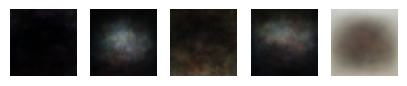

Images from Conv VAE


Generating images: 100%|██████████| 5/5 [00:00<00:00, 111.16image/s]


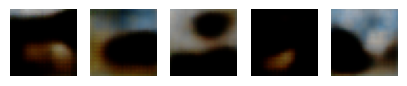

In [165]:
# Assuming you have already trained the model (vae) and it has a latent dimension of 128
print('Images from FC VAE')
generate_images(fcvae, num_images=5, latent_dim=128)

print('Images from Conv VAE')
generate_images(cvae, num_images=5, latent_dim=128)